#### Decomposition 

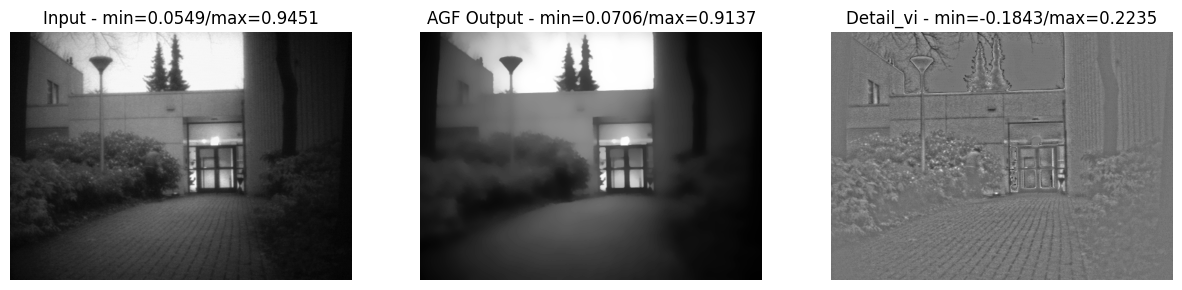

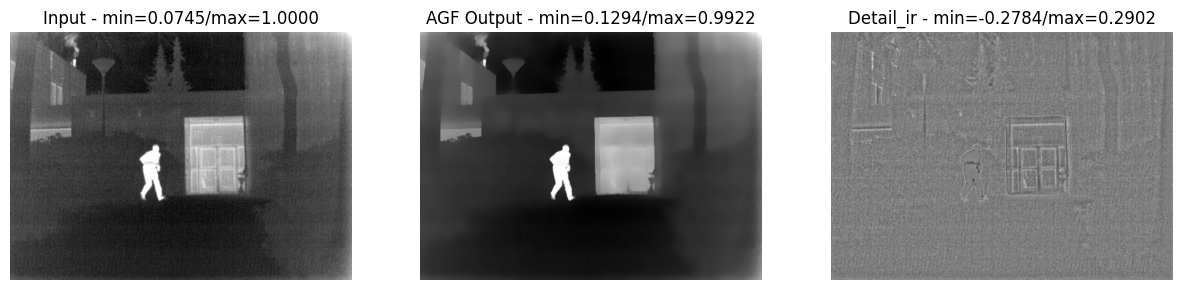

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from decomposition.AGF_decomposition import agf_decomposition

# Decompose the visible image
img_vi = cv2.imread(".\\data\\TNO\\vi\\17.png", cv2.IMREAD_GRAYSCALE)
img_vi = img_vi.astype(np.float32) / 255.0

base_vi, detail_vi = agf_decomposition(
    img_vi,
    sigma_spatial=5,
    sigma_range=0.05,
    iterations=4,
    median_ksize=3,
    numba=True
)

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1); plt.title(f"Input - min={img_vi.min():.4f}/max={img_vi.max():.4f}"); plt.imshow(img_vi, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"AGF Output - min={base_vi.min():.4f}/max={base_vi.max():.4f}"); plt.imshow(base_vi, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Detail_vi - min={detail_vi.min():.4f}/max={detail_vi.max():.4f}"); plt.imshow(detail_vi, cmap="gray"); plt.axis("off")
plt.show()

# Decompose the infrared image
img_ir = cv2.imread(".\\data\\TNO\\ir\\17.png", cv2.IMREAD_GRAYSCALE)
img_ir = img_ir.astype(np.float32) / 255.0  

base_ir, detail_ir = agf_decomposition(
    img_ir,
    sigma_spatial=5,
    sigma_range=0.05,
    iterations=4,
    median_ksize=3,
    numba=True
)

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1); plt.title(f"Input - min={img_ir.min():.4f}/max={img_ir.max():.4f}"); plt.imshow(img_ir, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"AGF Output - min={base_ir.min():.4f}/max={base_ir.max():.4f}"); plt.imshow(base_ir, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Detail_ir - min={detail_ir.min():.4f}/max={detail_ir.max():.4f}"); plt.imshow(detail_ir, cmap="gray"); plt.axis("off")
plt.show()

In [2]:
type(base_ir)

numpy.ndarray

c:\Users\ADMIN\OneDrive - Hanoi University of Science and Technology\Desktop\AGF_IVIF\base_PFCFuse\base_PFCFuse.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = t

(450, 620) 0.18739961 0.99999964


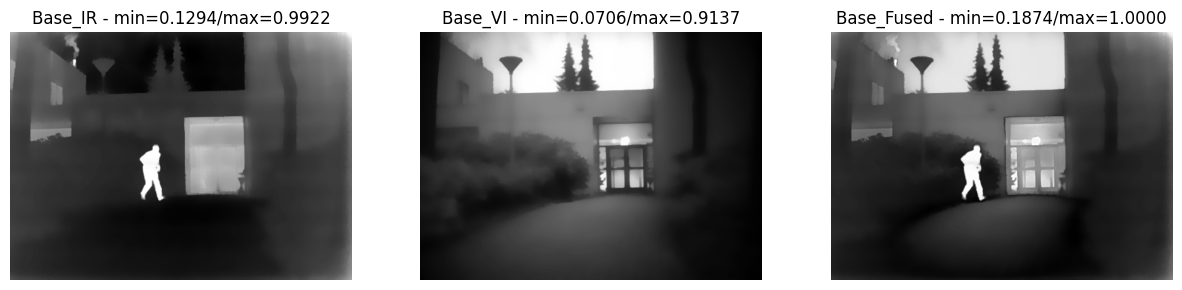

In [7]:
from base_PFCFuse.base_PFCFuse import pfcfuse_fuse_gray

base_fused = pfcfuse_fuse_gray(base_ir, base_vi)
print(base_fused.shape, base_fused.min(), base_fused.max())

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1); plt.title(f"Base_IR - min={base_ir.min():.4f}/max={base_ir.max():.4f}"); plt.imshow(base_ir, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"Base_VI - min={base_vi.min():.4f}/max={base_vi.max():.4f}"); plt.imshow(base_vi, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Base_Fused - min={base_fused.min():.4f}/max={base_fused.max():.4f}"); plt.imshow(base_fused, cmap="gray"); plt.axis("off")
plt.show()


In [2]:
restruct_vi = base_vi + detail_vi
restruct_ir = base_ir + detail_ir

# Tính PSNR giữa ảnh gốc và ảnh tái cấu trúc
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

psnr_vi = psnr(img_vi, restruct_vi)
psnr_ir = psnr(img_ir, restruct_ir)
print(f"PSNR between original and reconstructed visible image: {psnr_vi:.2f} dB")
print(f"PSNR between original and reconstructed infrared image: {psnr_ir:.2f} dB")

PSNR between original and reconstructed visible image: inf dB
PSNR between original and reconstructed infrared image: inf dB


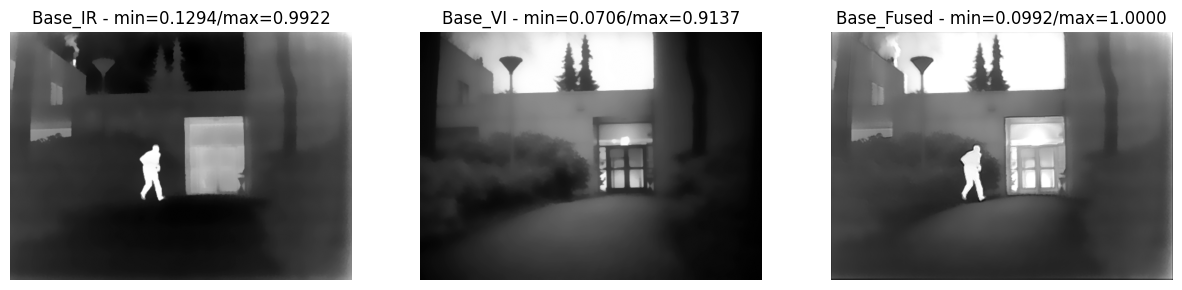

In [10]:
from base_fusion.base_fused import fuse_ir_vi_numpy

base_fused = fuse_ir_vi_numpy(
    ir_base=base_ir,
    vi_base=base_vi,
    model_path="F://AGF_IVIF//base_fusion//run//train_2//best_model.pth",
    device="cpu"
)

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1); plt.title(f"Base_IR - min={base_ir.min():.4f}/max={base_ir.max():.4f}"); plt.imshow(base_ir, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"Base_VI - min={base_vi.min():.4f}/max={base_vi.max():.4f}"); plt.imshow(base_vi, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Base_Fused - min={base_fused.min():.4f}/max={base_fused.max():.4f}"); plt.imshow(base_fused, cmap="gray"); plt.axis("off")
plt.show()


#### Detail Fusion

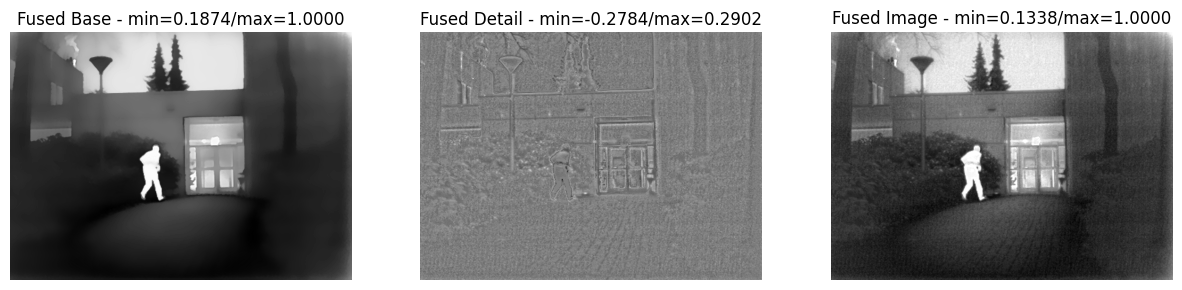

In [8]:
from detail_fusion.MVA_WLE import fuse_detail_dynamic_WLE_im2col_var_optimizer

# base_fused = np.maximum(base_vi, base_ir)
detail_fulsed = fuse_detail_dynamic_WLE_im2col_var_optimizer(detail_ir, detail_vi)
fused = np.clip(base_fused + detail_fulsed, 0, 1)

cv2.imwrite(".\\data\\output\\AGF_fusion_base.png", (fused * 255).astype(np.uint8))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.title(f"Fused Base - min={base_fused.min():.4f}/max={base_fused.max():.4f}"); plt.imshow(base_fused, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"Fused Detail - min={detail_fulsed.min():.4f}/max={detail_fulsed.max():.4f}"); plt.imshow(detail_fulsed, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Fused Image - min={fused.min():.4f}/max={fused.max():.4f}"); plt.imshow(fused, cmap="gray"); plt.axis("off")
plt.show()

In [9]:
import pandas as pd
from metric.eval_one_image import evaluation_one

ir_image = ".\\data\\TNO\\ir\\17.png"
vi_image = ".\\data\\TNO\\vi\\17.png"
fused_image = ".\\data\\output\\AGF_fusion_base.png"

EN, MI, SF, AG, SD, MLI, CC, SCD, VIF, MSE, PSNR, Qabf, Nabf, SSIM, MS_SSIM = evaluation_one(ir_image, vi_image, fused_image)

# Tạo bảng kết quả
data = {
    "Metric": [
        "EN", "MI", "SF", "AG", "SD", "MLI", "CC", "SCD",
        "VIF", "MSE", "PSNR", "Qabf", "Nabf", "SSIM", "MS_SSIM"
    ],
    "Value": [
        EN, MI, SF, AG, SD, MLI, CC, SCD,
        VIF, MSE, PSNR, Qabf, Nabf, SSIM, MS_SSIM
    ]
}

df = pd.DataFrame(data)

# Làm tròn cho đẹp (tuỳ chọn)
df["Value"] = df["Value"].round(6)

# Hiển thị bảng
print(df)


torch.Size([1, 1, 1, 450, 620]) torch.Size([1, 1, 1, 450, 620])
torch.Size([1, 1, 1, 450, 620]) torch.Size([1, 1, 1, 450, 620])
     Metric       Value
0        EN    7.155177
1        MI    3.351107
2        SF    9.159075
3        AG    3.741084
4        SD   52.336416
5       MLI  107.869949
6        CC    0.553684
7       SCD    1.746076
8       VIF    0.725169
9       MSE    0.042929
10     PSNR   61.803339
11     Qabf    0.588461
12     Nabf    0.028034
13     SSIM    0.470028
14  MS_SSIM    0.482736


In [ ]:
torch.Size([1, 1, 1, 450, 620]) torch.Size([1, 1, 1, 450, 620])
torch.Size([1, 1, 1, 450, 620]) torch.Size([1, 1, 1, 450, 620])
     Metric       Value
0        EN    7.071723
1        MI    3.001271
2        SF   10.304983
3        AG    3.992532
4        SD   58.135594
5       MLI  118.053345
6        CC    0.555643
7       SCD    1.771703
8       VIF    0.694899
9       MSE    0.057249
10     PSNR   60.553109
11     Qabf    0.549567
12     Nabf    0.042701
13     SSIM    0.460123
14  MS_SSIM    0.485458

#### Base Fusion

In [ ]:
import torch
import cv2
import numpy as np
from base_fusion.loss.loss import fusion_loss_vif

def load_gray_image(path, device):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Cannot load image: {path}")

    img = img.astype(np.float32) / 255.0
    img = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    return img.to(device)


def compute_fusion_loss(image1_path, image2_path, image_fused_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load images
    image_A = load_gray_image(image1_path, device)
    image_B = load_gray_image(image2_path, device)
    image_F = load_gray_image(image_fused_path, device)

    # Init loss
    criterion = fusion_loss_vif().to(device)

    # Compute loss
    fusion_loss, loss_grad, loss_l1, loss_ssim = criterion(
        image_A, image_B, image_F
    )

    return {
        "fusion_loss": fusion_loss.item(),
        "loss_gradient": loss_grad.item(),
        "loss_intensity": loss_l1.item(),
        "loss_ssim": loss_ssim.item(),
        "device": str(device)
    }


if __name__ == "__main__":
    image1_path = ".\\data\\TNO\\ir\\17.png"
    image2_path = ".\\data\\TNO\\vi\\17.png"
    image_fused_path = ".\\data\\output\\AGF_fusion_base.png"

    loss_dict = compute_fusion_loss(
        image1_path, image2_path, image_fused_path
    )

    for k, v in loss_dict.items():
        print(f"{k}: {v}")


fusion_loss: 3.6317129135131836
loss_gradient: 0.7227263450622559
loss_intensity: 0.16194561123847961
loss_ssim: 2.7470409870147705
device: cpu


#### Full Pipeline

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from decomposition.AGF_decomposition import agf_decomposition
from base_PFCFuse.base_PFCFuse import pfcfuse_fuse_gray
from detail_fusion.MVA_WLE import fuse_detail_dynamic_WLE_im2col_var_optimizer

dataset = "TNO"
number_images = 42
if dataset == "MSRS":
    number_images = 80
output_folder = "pfcfuse_gray_tno"
if not os.path.exists(f".\\data\\output\\{output_folder}"):
    os.makedirs(f".\\data\\output\\{output_folder}")

for i in range(number_images):
    number_image = i + 1
    if number_image < 10:
        code_image = '0'+str(number_image)
    else:
        code_image = str(number_image)

    # Decompose image
    img_vi = cv2.imread(f".\\data\\{dataset}\\vi\\{code_image}.png", cv2.IMREAD_GRAYSCALE)
    img_vi = img_vi.astype(np.float32) / 255.0
    img_ir = cv2.imread(f".\\data\\{dataset}\\ir\\{code_image}.png", cv2.IMREAD_GRAYSCALE)
    img_ir = img_ir.astype(np.float32) / 255.0  

    base_vi, detail_vi = agf_decomposition(
        img_vi,
        sigma_spatial=5,
        sigma_range=0.05,
        iterations=4,
        median_ksize=3,
        numba=True
    )

    base_ir, detail_ir = agf_decomposition(
        img_ir,
        sigma_spatial=5,
        sigma_range=0.05,
        iterations=4,
        median_ksize=3,
        numba=True
    )

    base_fused = pfcfuse_fuse_gray(base_ir, base_vi)

    detail_fulsed = fuse_detail_dynamic_WLE_im2col_var_optimizer(detail_ir, detail_vi)

    fused = np.clip(base_fused + detail_fulsed, 0, 1)

    cv2.imwrite(f".\\data\\output\\{output_folder}\\{code_image}.png", (fused * 255).astype(np.uint8))

    print(f"✅ Finished image {code_image}")


In [ ]:
import pandas as pd
from metric.eval_one_image import evaluation_one

# Danh sách lưu kết quả từng ảnh
dataset = "TNO"
root_folder = f".\\data\\output"

number_images = 42
if dataset == "MSRS":
    number_images = 80

for method in ["PFCFuse"]:
    results = []
    for i in range(number_images):
        number_image = i + 1
        code_image = f"{number_image:02d}"

        ir_image = f".\\data\\{dataset}\\vi\\{code_image}.png"
        vi_image = f".\\data\\{dataset}\\ir\\{code_image}.png"
        fused_image = f"{root_folder}\\{method}\\{code_image}.png"

        EN, MI, SF, AG, SD, MLI, CC, SCD, VIF, MSE, PSNR, Qabf, Nabf, SSIM, MS_SSIM = \
            evaluation_one(ir_image, vi_image, fused_image)

        results.append({
            "Image": code_image,
            "EN": EN,
            "MI": MI,
            "SF": SF,
            "AG": AG,
            "SD": SD,
            "MLI": MLI,
            "CC": CC,
            "SCD": SCD,
            "VIF": VIF,
            "MSE": MSE,
            "PSNR": PSNR,
            "Qabf": Qabf,
            "Nabf": Nabf,
            "SSIM": SSIM,
            "MS_SSIM": MS_SSIM
        })

    # Tạo DataFrame
    df = pd.DataFrame(results)

    # Làm tròn cho đẹp
    df = df.round(6)

    # Tính trung bình
    mean_row = df.drop(columns=["Image"]).mean()
    mean_row["Image"] = "Mean"

    # Ghép dòng Mean vào cuối bảng
    df = pd.concat([df, mean_row.to_frame().T], ignore_index=True)

    # Lưu ra Excel
    output_excel = f"{root_folder}\\{method}\\metrics_{dataset}.xlsx"
    df.to_excel(output_excel, index=False)

    print(f"✓ Saved metrics to {output_excel}")
    print(df)
